# Assignment: Financial Applications of Time Series
* Choose either the Signal Frontier Analysis application or Future Contract Rolling application.
    * Case studies start on page 345
* Use different stocks than those shown in examples.
* Create iPython Notebook, including code, output, and graphics.
* Include an introduction in your notebook to give background on your application.
* Be sure to explain calculations and output in the appropriate places.
* List outside references if used.


Case study write-ups are to be “technical report ready,” which basically means that the write-up is suitable for public viewing.

Your name must be at the beginning of the notebook.
The notebook should divided into an abstract, an introduction, a methods section, a results section, and a future work/discussion/conclusion section.
Use an easy-to-read variable-width font (I like Ariel, Helvetica, and Geneva font) with a minimum of 11 point font.
Relevant code and output must be explained in the notebook as close to the code/output as possible.
Any graphics generated using the code must be explained in the notebook as close to the graphic as possible.

## MUST SUBMIT AS A WORD DOC IN ADDITION TO ANYTHING DONE IN IPYTHON

In [9]:
from pandas import Series, DataFrame
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas_datareader import data as web
from dateutil.parser import parse
from pyfinance.ols import PandasRollingOLS
from datetime import datetime
pd.options.display.max_rows = 12
np.set_printoptions(precision=4, suppress=True)


## Future Contract Rolling

In [6]:
## First I am going to replicate the analysis, then change things up
price = web.get_data_yahoo('SPY')['Adj Close'] * 10

In [7]:
price

Date
2010-01-04     945.454941
2010-01-05     947.957840
2010-01-06     948.625259
2010-01-07     952.629547
2010-01-08     955.799713
2010-01-11     957.134552
                 ...     
2019-02-19    2778.500061
2019-02-20    2784.100037
2019-02-21    2774.200134
2019-02-22    2791.400146
2019-02-25    2795.199890
2019-02-26    2793.200073
Name: Adj Close, Length: 2302, dtype: float64

In [11]:
expires = {'ESU2': datetime(2012, 9, 21),
           'ESZ2': datetime(2012, 12, 21)}
expires = Series(expires).sort_values()

In [12]:
expires

ESU2   2012-09-21
ESZ2   2012-12-21
dtype: datetime64[ns]

In [15]:
np.random.seed(12347)
N = 200
walk = (np.random.randint(0, 200, size=N) - 100) * 0.25
perturb = (np.random.randint(0, 20, size=N) - 10) *0.25
walk = walk.cumsum()

rng = pd.date_range(price.index[0], periods=len(price) + N, freq='B')
near = np.concatenate([price.values, price.values[-1] + walk])
far = np.concatenate([price.values, price.values[-1] + walk + perturb])
prices = DataFrame({'ESU2': near, 'ESZ2': far}, index=rng)

In [17]:
prices.tail()

,ESU2,ESZ2
2019-07-31,2822.450073,2824.200073
2019-08-01,2808.700073,2810.950073
2019-08-02,2816.700073,2818.450073
2019-08-05,2833.200073,2832.450073
2019-08-06,2813.200073,2810.950073


In [58]:
def get_roll_weights(start, expiry, items, roll_periods=5):
    # start : first date to compute weighting DataFrame
    # expiry : Series of ticker -> expiration dates
    # items : sequence of contract names

    dates = pd.date_range(start, expiry[-1], freq='B')
    weights = DataFrame(np.zeros((len(dates), len(items))),
                        index=dates, columns=items)

    prev_date = weights.index[0]
    for i, (item, ex_date) in enumerate(expiry.iteritems()):
        if i < len(expiry) - 1:
            weights.ix[prev_date:ex_date - pd.offsets.BDay(), item] = 1
            roll_rng = pd.date_range(end=ex_date - pd.offsets.BDay(),
                                     periods=roll_periods + 1, freq='B')

            decay_weights = np.linspace(0, 1, roll_periods + 1)
            weights.ix[roll_rng, item] = 1 - decay_weights
            weights.ix[roll_rng, expiry.index[i + 1]] = decay_weights
        else:
            weights.ix[prev_date:, item] = 1

        prev_date = ex_date

    return weights



In [59]:
rweights = get_roll_weights('6/1/2012', expires, prices.columns)

/home/kyle/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  del sys.path[0]
/home/kyle/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/home/kyle/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/home/kyle/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: Depr

In [61]:
rweights.ix['2012-09-12':'2012-09-21']

/home/kyle/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


,ESU2,ESZ2
2012-09-12,1.0,0.0
2012-09-13,1.0,0.0
2012-09-14,0.8,0.2
2012-09-17,0.6,0.4
2012-09-18,0.4,0.6
2012-09-19,0.2,0.8
2012-09-20,0.0,1.0
2012-09-21,0.0,1.0


In [65]:
rolled_returns = (prices.pct_change() * rweights).sum(1)

In [66]:
rolled_returns

2010-01-04    0.0
2010-01-05    0.0
2010-01-06    0.0
2010-01-07    0.0
2010-01-08    0.0
2010-01-11    0.0
             ... 
2019-07-30    0.0
2019-07-31    0.0
2019-08-01    0.0
2019-08-02    0.0
2019-08-05    0.0
2019-08-06    0.0
Freq: B, Length: 2502, dtype: float64

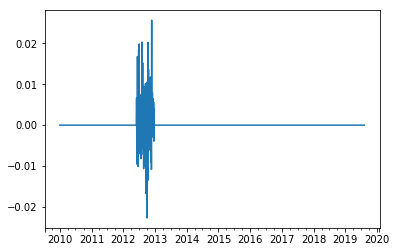

In [67]:
rolled_returns.plot()